In [27]:
import os, sys
from pathlib import Path
import loader 
import utils
from torch.utils.data import DataLoader
import torch 
import torchvision
# --------------------------- load Parameters from config ----------------------------------
config_path = os.path.join(Path.cwd(),'models\\VisionTransformer\\config.yaml')
params = utils.get_config_from_yaml(config_path)


# the dataset is set up he coppes images out of the original image i the set size 
# each epoch he takes a new slice of the original image 
# recomended sizes [64,64] / [128,128] / [256, 256]  
HE_img_dir = os.path.join(params['train_dir'],'HE')
IHC_img_dir = os.path.join(params['train_dir'],'IHC')
           
num_patches = (1024 * 1024) // params['img_size'][0]**2 


train_data = loader.stain_transfer_dataset( img_patch=  1,
                                           img_size=[256,256],
                                            params= params,
                                            HE_img_dir = HE_img_dir,
                                            IHC_img_dir = IHC_img_dir,                                                     
                                           )
            
# get dataloader
train_data_loader = DataLoader(train_data, batch_size=1, shuffle=False) 

            
real_HE, real_IHC,img_name = next(iter(train_data_loader))
contrast_IHC = torchvision.transforms.functional.adjust_contrast(real_IHC,3)


In [1]:
import utils
import numpy as np 
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

model_architectures = {}
#model_architectures["U-Net"] = ['my_UNet','my_UNet_color_loss_only']
#model_architectures["diffusion_model"] = ['diff_1000t_loaded']
#model_architectures["pix2pix"] = ['my_UNet_color_loss_only','Transformer']
model_architectures["ViT"] = ['Vit_1Block_4Mlp_4pat_mse+gaus']
model_architectures["swin_transformer"] = ['2_stage_win4_96_dim_+gaus']
images = {}
images["img_num"]=[2,4,65,45]
images["patch_num"]= [0,0,0,0]

grid = utils.publishing_plot(images, model_architectures)



def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
show(grid)

c:\Users\phili\OneDrive\Uni\WS_22\Masterarbeit\Masterarbeit_Code_Philipp_Rosin\torch_stain_transfer\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\phili\\OneDrive\\Uni\\WS_22\\Masterarbeit\\Masterarbeit_Code_Philipp_Rosin\\torch_stain_transfer\\code\\masterthesis_results\\ViT\\Vit_1Block_4Mlp_4pat_mse+gaus\\config.yaml'

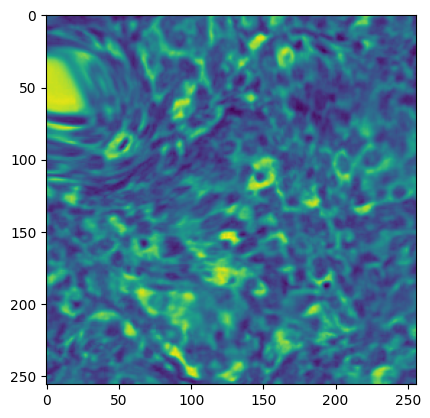

In [3]:
import matplotlib.pyplot as plt
import numpy as np
size=16
stride=16
patches = real_HE.unfold(2, size, stride).unfold(3, size, stride)
img = real_HE[:,1,:,:]
img = img.cpu().numpy()
img = np.transpose(img, axes=[1,2,0])
fig = plt.figure()
plt.imshow(img )

In [4]:
from torch import nn
#-----------------------------------------------------------------------------------------------
# PATCH EMBEDDING
#-----------------------------------------------------------------------------------------------
class patch_embedding(nn.Module):
    def __init__(self, in_channels, patch_size):
        super().__init__()
# ---------- inputs -------------------
# [N, in_channels, in_height, in_width]
# in_channels ------> int: number of channels in 
# patch_size -------> [w,h] : size of patch
#
# ---------- output -------------------
# P = patch_dim = (patch_size**2)* in_channels
# D = lossles embedding_dim = (in_width/patch_size[0])**2
# [N, P, D]
        self.in_channels = in_channels
        self.patch_size = patch_size
        self.patch_dim = (patch_size[0]**2)* in_channels

        assert patch_size[0] == patch_size[1], "patch_embedding is only for square patches"

        self.patcher = nn.Conv2d(   in_channels=in_channels,
                                    out_channels = self.patch_dim,
                                    kernel_size = patch_size[0],
                                    stride = patch_size[0],
                                    padding = 0)
        
        self.flatten = nn.Flatten(  start_dim=2, 
                                    end_dim=3)
        
    def forward(self, x):
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 

        return x_flattened

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 768, 256])


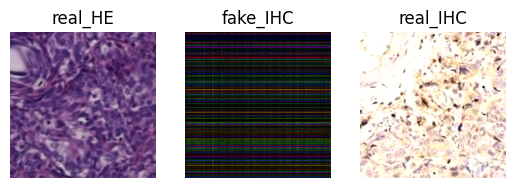

In [14]:

import math
patch_size = [16,16]
num_heads = 8
embedding_dim = int((256/16)**2)
x = real_HE

n, c, h, w = x.shape
patch_emb = patch_embedding(3,patch_size).to('cuda')
patches = patch_emb(x)
print(patches.shape)
unflatten = nn.Unflatten(2,(int(math.sqrt(embedding_dim)), int(math.sqrt(embedding_dim))))

unflatten = unflatten(patches)
reshaped = unflatten.reshape([n,c,h,w])

utils.plot_img_set(real_HE, reshaped, contrast_IHC, 3,params,img_name,'train',1)


In [4]:
from torch import nn
import torch 
x = torch.randn((1, 3072, 8, 8)).cuda()
x_1 = torch.randn((1, 3072, 64)).cuda()
model = nn.Conv2d(3072, 3, 1, 1, 0).cuda()
mlp = nn.Linear(64,64).cuda()
y_1 = mlp(x_1)
print(y_1.shape)
y = model(x)
print(y.shape)

torch.Size([1, 3072, 64])
torch.Size([1, 3, 8, 8])


In [ ]:
from U_net_pytorch import UNet
model = UNet(in_channels=params['in_channels'],out_channels=3, init_features=32).to(params['device'])
#model = U_net_Generator(in_channels=params['in_channels'], features=params['gen_features']).to(params['device'])

model_testing = eval.test_network(model,params,training_time)
model_testing.fit()

In [ ]:
def sample(self, model, n):
        #logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        
        return x


In [1]:
import tifffile as tiff 
a = tiff.imread("C:/Users/phili/OneDrive/Uni/WS_22/Masterarbeit/Masterarbeit_Code_Philipp_Rosin/peso_data/pds_2_HE.tif")

In [41]:
import pickle
path = "C:/Users/phili/OneDrive/Uni/WS_22/Masterarbeit/Masterarbeit_Code_Philipp_Rosin/torch_stain_transfer/masterthesis_results/U-Net/my_UNet_4step_32/train_result"
x={}
l = [1,2,3,4]
s = [0.4334,2.4232,12313,0.5543]
x['a'] = l
x['b'] = s
with open("test", "wb") as fp:   #Pickling
   pickle.dump(x, fp)
 
with open(path, "rb") as fp:   # Unpickling
   b = pickle.load(fp)

print(b['mse'].type())

AttributeError: 'list' object has no attribute 'type'

In [76]:
# -------------------------------------------------------------------------------------------------------------------------
# Generator based on U-net 
# -------------------------------------------------------------------------------------------------------------------------
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

# ---------------------------------- double same convolution --------------------------------------------------------------
# -------> input_size of image = output_size of image
# -------> code was extended by batchnorm from the origilan paper

class DoubleConv_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv_block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

# upconv block 
class up_conv(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(out_channels),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x
# ---------------------------------- U_net implimentation -----------------------------------------------------------------
# in_channels = num of channels in the input image 
# out_channels = num of channels in the input image 
# len(features) = number of steps of the down and upward part of the U_net
# features =  number of filters in the single step 
# each step is linkt with a skip connection to the opposite step 
class U_net_Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=64, steps=7, attention=False):
        super(U_net_Generator, self).__init__()
        if steps < 3 or steps >=7:
            print('steps have to be between 3 and 6 ')
        else:
            self.steps = steps
            self.attention = attention
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        # outer step
        self.Conv1 = DoubleConv_block(in_channels=in_channels,out_channels=features)
        self.Conv_1x1 = nn.Conv2d(features,out_channels,kernel_size=1,stride=1,padding=0)

        # second step
        self.Conv2 = DoubleConv_block(in_channels=features,out_channels=int(features*2))
        self.Up2 = up_conv(in_channels=int(features*2), out_channels=features)
        if attention:
            self.Att2 = Attention_block(F_g=features,F_l=features,F_int=int(features/2))
        self.Up_conv2 = DoubleConv_block(in_channels=int(features*2), out_channels=features)

        # third step
        self.Conv3 = DoubleConv_block(in_channels=int(features*2),out_channels=int(features*4))
        self.Up3 = up_conv(in_channels=int(features*4),out_channels=int(features*2))
        if attention:
            self.Att3 = Attention_block(F_g=int(features*2),F_l=int(features*2),F_int=int(features))
        self.Up_conv3 = DoubleConv_block(in_channels=int(features*4),out_channels=int(features*2))

        # fourth step
        if self.steps >= 4:
            self.Conv4 = DoubleConv_block(in_channels=int(features*4),out_channels=int(features*8))
            self.Up4 = up_conv(in_channels=int(features*8),out_channels=int(features*4))
            if attention:
                self.Att4 = Attention_block(F_g=int(features*4),F_l=int(features*4),F_int=int(features*2))
            self.Up_conv4 = DoubleConv_block(in_channels=int(features*8),out_channels=int(features*4))

        # fith step 
        if self.steps >=5:
            self.Conv5 = DoubleConv_block(in_channels=int(features*8),out_channels=int(features*16))
            self.Up5 = up_conv(in_channels=int(features*16),out_channels=int(features*8))
            if attention:
                self.Att5 = Attention_block(F_g=int(features*8),F_l=int(features*8),F_int=int(features*4))
            self.Up_conv5 = DoubleConv_block(in_channels=int(features*16),out_channels=int(features*8))

        # sixth step
        if self.steps >=6:
            self.Conv6 = DoubleConv_block(in_channels=int(features*16),out_channels=int(features*32))
            self.Up6 = up_conv(in_channels=int(features*32),out_channels=int(features*16))
            if attention:
                self.Att6 = Attention_block(F_g=int(features*16),F_l=int(features*16),F_int=int(features*8))
            self.Up_conv6 = DoubleConv_block(in_channels=int(features*32),out_channels=int(features*16))


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)
        

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)
        

        if self.steps>=4:
            x4 = self.Maxpool(x3)
            x4 = self.Conv4(x4)
            

        if self.steps>=5:
            x5 = self.Maxpool(x4)
            x5 = self.Conv5(x5)
            

        if self.steps==6:
            x6 = self.Maxpool(x5)
            x6 = self.Conv6(x6)

            d6 = self.Up6(x6)
            if self.attention:
                x5 = self.Att6(g=d6,x=x5)
            d6 = torch.cat((x5,d6),dim=1)        
            d6 = self.Up_conv6(d6)
            

        if self.steps>=5:
            if self.steps == 5: 
                in5 = x5
            else :
                in5 = d6

            d5 = self.Up5(in5)
            if self.attention:
                x4 = self.Att5(g=d5,x=x4)
            d5 = torch.cat((x4,d5),dim=1)        
            d5 = self.Up_conv5(d5)

        if self.steps>=4:
            if self.steps == 4: 
                in4 = x4
            else :
                in4 = d5
                
            d4 = self.Up4(in4)
            if self.attention:
                x3 = self.Att4(g=d4,x=x3)
            d4 = torch.cat((x3,d4),dim=1)
            d4 = self.Up_conv4(d4)


        if self.steps == 3: 
            in3 = x3
        else :
            in3 = d4
        d3 = self.Up3(in3)
        if self.attention:
            x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        if self.attention:
            x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return torch.sigmoid(d1)

           
class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi
    


In [19]:
import argparse
def my_args(no_parsing=False, getparser=False):
    parser = argparse.ArgumentParser()
    # Musts
    parser.add_argument('--model', type=str, default="", help='model architecture')
    parser.add_argument('--type', type=str, default="", help='scope of the model')

    # training 
    parser.add_argument('--img_size', type=int, default=256, help='Image size')
    parser.add_argument('--in_channels', type=int, default=3, help='input channels')
    parser.add_argument('--epoch_num', type=int, default=100, help='epoch num')
    parser.add_argument('--decay_epoch', type=int, default=80, help='decay epoch num')
    parser.add_argument('--batch_size', type=int, default=1, help='batch size')
    parser.add_argument('--device', type=str, default="cuda", help='device')
    parser.add_argument('--str_liste', type=list, default=["hallo","firend"], help='Image size')
    parser.add_argument('--diff_model', action='store_true', default=False, help='use diffusion model')

    # testing
    parser.add_argument('--only_test', type=str, default="cuda", help='device')

    if no_parsing:
        return parser.parse_args([])
    if getparser:
        return parser.parse_args(), parser
    return parser.parse_args() 

args, parser = my_args(getparser=True)
print(args)

usage: ipykernel_launcher.py [-h] [--model MODEL] [--type TYPE]
                             [--img_size IMG_SIZE] [--in_channels IN_CHANNELS]
                             [--epoch_num EPOCH_NUM]
                             [--decay_epoch DECAY_EPOCH]
                             [--batch_size BATCH_SIZE] [--device DEVICE]
                             [--str_liste STR_LISTE] [--diff_model]
                             [--only_test ONLY_TEST]
ipykernel_launcher.py: error: unrecognized arguments: --ip=127.0.0.1 --stdin=9003 --control=9001 --hb=9000 --Session.signature_scheme="hmac-sha256" --Session.key=b"5969f226-6929-4982-8430-82395c95d3d6" --shell=9002 --transport="tcp" --iopub=9004 --f=c:\Users\phili\AppData\Roaming\jupyter\runtime\kernel-v2-23312xJohdI0QNDbS.json


SystemExit: 2

c:\Users\phili\OneDrive\Uni\WS_22\Masterarbeit\Masterarbeit_Code_Philipp_Rosin\torch_stain_transfer\env\lib\site-packages\IPython\core\interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


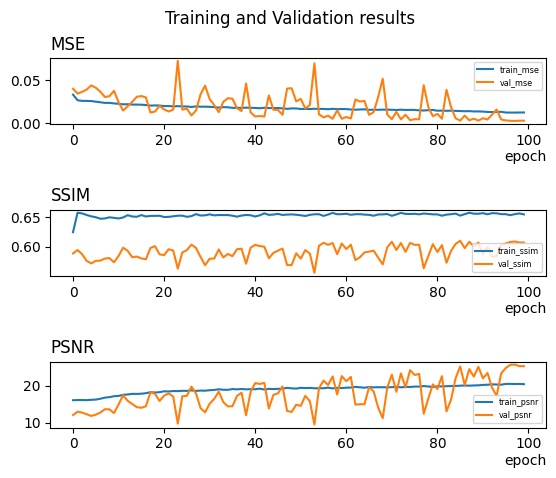

In [20]:
import os
import pickle
import matplotlib.pyplot as plt
path = 'C:/Users/phili/OneDrive/Uni/WS_22/Masterarbeit/Masterarbeit_Code_Philipp_Rosin/torch_stain_transfer/masterthesis_results/U-Net/4step_32f/train_result'
save_path ='C:/Users/phili/OneDrive/Uni/WS_22/Masterarbeit/Masterarbeit_Code_Philipp_Rosin/torch_stain_transfer/masterthesis_results/U-Net/4step_32f'
def plot_trainresult(save_path,train_eval):
        x = range(len(train_eval['train_mse']))
        fig, axs = plt.subplots(3)
        fig.suptitle('Training and Validation results')

        axs[0].plot(x, train_eval['train_mse'],label='train_mse')
        
        axs[0].plot(x, train_eval['val_mse'],label='val_mse')
        axs[0].legend(loc="upper right",fontsize='xx-small')
        axs[0].set_xlabel(xlabel='epoch',loc='right',labelpad=2)
        axs[0].set_title('MSE',loc='left')

        axs[1].plot(x, train_eval['train_ssim'],label='train_ssim')
      
        axs[1].plot(x, train_eval['val_ssim'],label='val_ssim')
        axs[1].legend(loc="lower right",fontsize='xx-small')
        axs[1].set_xlabel(xlabel='epoch',loc='right',labelpad=2)
        axs[1].set_title('SSIM',loc='left')

        axs[2].plot(x, train_eval['train_psnr'],label='train_psnr')
       
        axs[2].plot(x, train_eval['val_psnr'],label='val_psnr')
        axs[2].legend(loc="lower right",fontsize='xx-small')
        axs[2].set_xlabel(xlabel='epoch',loc='right',labelpad=2)
        axs[2].set_title('PSNR',loc='left')
        
        plt.subplots_adjust(hspace=1.3)
        fig.savefig(os.path.join(save_path,"train_result.png"))


with open(path, "rb") as fp:   # Unpickling
    train_eval = pickle.load(fp)
            
plot_trainresult(save_path,train_eval)


In [22]:
score =2
for n in range(len(train_eval['train_mse'])):
    current_score =train_eval['val_mse'][n]+(1-train_eval['val_ssim'][n])
    if current_score<score:
        score = current_score
        idx = n

print(idx)


85


In [27]:
from architectures.U_net_Generator_model import U_net_Generator
import torch
path ='C:/Users/phili/OneDrive/Uni/WS_22/Masterarbeit/Masterarbeit_Code_Philipp_Rosin/torch_stain_transfer/masterthesis_results/U-Net/4step_32f'
features= 32
steps = 4
model = U_net_Generator( in_channels=3 , out_channels=3, features=features, steps=steps, attention=False)
best_model_weights = os.path.join(path,'checkpoints/gen_G_weights_85.pth')
model.load_state_dict(torch.load(best_model_weights))
final_model_path = os.path.join(path,'final_weights_gen.pth')
torch.save(model.state_dict(), final_model_path)